In [137]:
import ast
import numpy as np
import os
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from numpy import genfromtxt
from scipy.io import loadmat
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils import data
import math  
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

### Reformat data files 

In [2]:
files = os.listdir('./dataset/Networks/')
files

['Sim_drugsideEffect.txt',
 'Sim_drugDisease.txt',
 'drugsim2network.txt',
 'proteinDisease.txt',
 'proteinsim3network.txt',
 'proteinsim4network.txt',
 'drugsim5network.txt',
 'drugdrug.txt',
 'proteinsim1network.txt',
 'proteinprotein.txt',
 'drugDisease.txt',
 'drugsim3network.txt',
 'proteinsim2network.txt',
 'drugsim6network.txt',
 'drugsideEffect.txt',
 'drugsim1network.txt',
 'drugsim4network.txt',
 'Sim_proteinDisease.txt']

In [3]:
s = open('./dataset/drug_dict.txt', 'r').read()
s = s.replace(":","\t")

In [4]:
s = 'Code\tName\n' + s
file = open('./labels/drug_labels.txt','w+')

In [5]:
file.write("")
file.write(s)

14610

In [6]:
s = open('./dataset/disease_dict.txt', 'r').read()
s = s.replace(":","\t")

In [7]:
s = 'Code\tName\n' + s
file = open('./labels/disease_labels.txt','w+')
file.write("")
file.write(s)

12645

In [8]:
s = open('./dataset/protein_dict.txt', 'r').read()
s = s.replace(":","\t")

In [9]:
s = "GeneID\tName\n" + s
file = open('./labels/protein_labels.txt','w+')
file.write("")
file.write(s)

21115

In [10]:
import IPython
url = 'https://projector.tensorflow.org/'

IPython.display.IFrame(url, width=1300, height=700)

### Opening similarity matricies in numpy

In [11]:
p_sequence = genfromtxt('./dataset/Networks/proteinsim1network.txt', delimiter = "\t")
p_biological = genfromtxt('./dataset/Networks/proteinsim2network.txt', delimiter = "\t")
p_cellular = genfromtxt('./dataset/Networks/proteinsim3network.txt', delimiter = "\t")
p_molecular = genfromtxt('./dataset/Networks/proteinsim4network.txt', delimiter = "\t")


In [12]:
p_sequence.shape

(1915, 1915)

In [13]:
p_biological.shape

(1915, 1915)

In [14]:
p_cellular.shape

(1915, 1915)

In [15]:
p_molecular.shape

(1915, 1915)

In [16]:
p = pd.read_csv('./labels/protein_labels.txt', sep = "\t")

In [17]:
p.shape

(1915, 2)

In [18]:
d_chem = genfromtxt('./dataset/Networks/drugsim1network.txt', delimiter = "\t")
d_ther = genfromtxt('./dataset/Networks/drugsim2network.txt', delimiter = "\t")
d_seq = genfromtxt('./dataset/Networks/drugsim3network.txt', delimiter = "\t")
d_bio = genfromtxt('./dataset/Networks/drugsim4network.txt', delimiter = "\t")
d_cellular = genfromtxt('./dataset/Networks/drugsim5network.txt', delimiter = "\t")
d_molecular = genfromtxt('./dataset/Networks/drugsim6network.txt', delimiter = "\t")


In [19]:
d_chem.shape

(732, 732)

In [20]:
d_ther.shape

(732, 732)

In [21]:
d_seq.shape

(732, 732)

In [22]:
d_bio.shape

(732, 732)

In [23]:
d_cellular.shape

(732, 732)

In [24]:
d_molecular.shape

(732, 732)

In [25]:
d = pd.read_csv('./labels/drug_labels.txt', sep = "\t")

In [26]:
d.shape

(732, 2)

In [27]:
drug_sim = np.concatenate((d_chem,d_ther,d_seq,d_bio,d_cellular,d_molecular), axis = 1)

In [28]:
print(d.shape)
print(drug_sim.shape)

(732, 2)
(732, 4392)


In [29]:
p_sim = np.concatenate((p_sequence,p_biological,p_cellular,p_molecular), axis = 1)

In [30]:
print(p.shape)
print(p_sim.shape)

(1915, 2)
(1915, 7660)


In [31]:
protein_to_disease = genfromtxt('./dataset/Networks/proteinDisease.txt', delimiter = "\t")

In [32]:
protein_to_disease.shape

(1915, 440)

In [33]:
drug_to_disease = genfromtxt('./dataset/Networks/drugDisease.txt', delimiter = "\t")

In [34]:
drug_to_disease.shape

(732, 440)

In [35]:
protein_labels = []
with open('./labels/protein_labels.txt', 'r') as file:
    for entry in file:
        e = entry.split()
        protein_labels.append([e[0],e[1]])
len(protein_labels)

1916

In [36]:
drug_labels = []
with open('./labels/drug_labels.txt', 'r') as file:
    for entry in file:
        e = entry.split()
        drug_labels.append([e[0],e[1]])
len(drug_labels)

733

In [37]:
disease_labels = []
with open('./labels/disease_labels.txt', 'r') as file:
    for entry in file:
        e = entry.split()
        disease_labels.append([e[0],e[1]])
len(disease_labels)

441

In [38]:
np.nonzero(drug_to_disease[6])

(array([ 43, 414]),)

## Protein 

In [39]:
np.array(protein_labels)[1:,1].shape

(1915,)

In [40]:
protein_sequence_sim = pd.DataFrame(p_sequence, index = np.array(protein_labels)[1:,1], columns = np.array(protein_labels)[1:,1])
protein_sequence_sim

,ADA,AKT3,GNPDA1,HDAC6,HDAC5,CDH5,PARP2,PARP3,ABCC9,NR1H3,...,LCMT2,CDK11B,TLK1,NUAK1,CDC25B,XYLB,OXSR1,HS3ST3A1,NR1I3,NR1H4
ADA,1.00000,0.17464,0.18115,0.12212,0.12048,0.15155,0.16134,0.17552,0.111970,0.16632,...,0.16124,0.15360,0.14452,0.15659,0.16641,0.18432,0.16982,0.16702,0.17293,0.18901
AKT3,0.17464,1.00000,0.17135,0.13286,0.12915,0.16361,0.17311,0.19167,0.120350,0.17020,...,0.16451,0.18088,0.20220,0.22688,0.16794,0.17156,0.20848,0.16502,0.16963,0.18260
GNPDA1,0.18115,0.17135,1.00000,0.10141,0.11547,0.13539,0.14144,0.15427,0.096909,0.14411,...,0.13572,0.13165,0.13231,0.13676,0.14607,0.15732,0.16696,0.16979,0.16986,0.16901
HDAC6,0.12212,0.13286,0.10141,1.00000,0.23806,0.15461,0.13858,0.14042,0.155720,0.13052,...,0.16428,0.14290,0.14300,0.14892,0.13971,0.15183,0.15097,0.12896,0.11390,0.12966
HDAC5,0.12048,0.12915,0.11547,0.23806,1.00000,0.15737,0.15110,0.16483,0.153120,0.13875,...,0.16029,0.17150,0.16998,0.15272,0.16508,0.14535,0.14645,0.12969,0.11747,0.13939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLB,0.18432,0.17156,0.15732,0.15183,0.14535,0.16592,0.17896,0.17832,0.119700,0.17244,...,0.18343,0.14161,0.16071,0.16676,0.17083,1.00000,0.18651,0.17435,0.16818,0.16896
OXSR1,0.16982,0.20848,0.16696,0.15097,0.14645,0.18196,0.17470,0.17056,0.127320,0.16274,...,0.17081,0.16070,0.15758,0.24370,0.16200,0.18651,1.00000,0.16340,0.16284,0.17287
HS3ST3A1,0.16702,0.16502,0.16979,0.12896,0.12969,0.14733,0.16674,0.17147,0.104190,0.17041,...,0.16867,0.14974,0.14583,0.14619,0.17938,0.17435,0.16340,1.00000,0.16560,0.18279
NR1I3,0.17293,0.16963,0.16986,0.11390,0.11747,0.13349,0.16074,0.17021,0.101710,0.32226,...,0.16026,0.15950,0.14576,0.15114,0.16620,0.16818,0.16284,0.16560,1.00000,0.30444


In [41]:
protein_biological_sim = pd.DataFrame(p_biological, index = np.array(protein_labels)[1:,1], columns = np.array(protein_labels)[1:,1])
protein_biological_sim

,ADA,AKT3,GNPDA1,HDAC6,HDAC5,CDH5,PARP2,PARP3,ABCC9,NR1H3,...,LCMT2,CDK11B,TLK1,NUAK1,CDC25B,XYLB,OXSR1,HS3ST3A1,NR1I3,NR1H4
ADA,1.000,0.217,0.204,0.274,0.309,0.236,0.674,0.375,0.251,0.270,...,0.330,0.327,0.224,0.316,0.234,0.284,0.292,0.360,0.400,0.420
AKT3,0.217,1.000,0.175,0.288,0.307,0.477,0.298,0.228,0.434,0.235,...,0.121,0.294,0.443,0.476,0.292,0.161,0.473,0.124,0.526,0.328
GNPDA1,0.204,0.175,1.000,0.188,0.169,0.171,0.274,0.188,0.164,0.132,...,0.173,0.225,0.179,0.198,0.217,0.436,0.205,0.265,0.206,0.190
HDAC6,0.274,0.288,0.188,1.000,0.523,0.292,0.425,0.320,0.278,0.430,...,0.150,0.358,0.403,0.402,0.301,0.205,0.375,0.184,0.359,0.410
HDAC5,0.309,0.307,0.169,0.523,1.000,0.310,0.382,0.303,0.273,0.427,...,0.182,0.443,0.347,0.345,0.290,0.194,0.356,0.179,0.481,0.503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLB,0.284,0.161,0.436,0.205,0.194,0.164,0.285,0.242,0.151,0.152,...,0.217,0.277,0.269,0.259,0.282,1.000,0.308,0.554,0.266,0.265
OXSR1,0.292,0.473,0.205,0.375,0.356,0.385,0.460,0.395,0.423,0.310,...,0.232,0.553,0.672,0.684,0.633,0.308,1.000,0.226,0.532,0.401
HS3ST3A1,0.360,0.124,0.265,0.184,0.179,0.159,0.290,0.253,0.154,0.165,...,0.316,0.264,0.187,0.197,0.229,0.554,0.226,1.000,0.301,0.318
NR1I3,0.400,0.526,0.206,0.359,0.481,0.402,0.440,0.344,0.447,0.459,...,0.288,0.449,0.480,0.509,0.332,0.266,0.532,0.301,1.000,0.650


In [42]:
protein_cellular_sim = pd.DataFrame(p_cellular, index = np.array(protein_labels)[1:,1], columns = np.array(protein_labels)[1:,1])
protein_cellular_sim

,ADA,AKT3,GNPDA1,HDAC6,HDAC5,CDH5,PARP2,PARP3,ABCC9,NR1H3,...,LCMT2,CDK11B,TLK1,NUAK1,CDC25B,XYLB,OXSR1,HS3ST3A1,NR1I3,NR1H4
ADA,1.000,0.759,0.553,0.606,0.591,0.722,0.407,0.447,0.562,0.402,...,1.000,0.640,0.640,0.577,0.601,0.553,0.553,0.505,0.595,0.295
AKT3,0.759,1.000,0.596,0.659,0.880,0.506,0.720,0.491,0.537,0.633,...,0.784,0.704,0.704,0.718,0.743,0.596,0.596,0.723,0.833,0.623
GNPDA1,0.553,0.596,1.000,0.515,0.575,0.319,0.394,0.447,0.260,0.351,...,0.784,0.506,0.506,0.582,0.587,1.000,1.000,0.439,0.627,0.297
HDAC6,0.606,0.659,0.515,1.000,0.713,0.406,0.560,0.575,0.359,0.549,...,1.000,1.000,1.000,0.678,0.719,0.515,0.515,0.504,0.672,0.445
HDAC5,0.591,0.880,0.575,0.713,1.000,0.324,0.853,0.491,0.281,0.762,...,0.784,1.000,1.000,0.803,0.772,0.575,0.575,0.723,0.937,0.709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLB,0.553,0.596,1.000,0.515,0.575,0.319,0.394,0.447,0.260,0.351,...,0.784,0.506,0.506,0.582,0.587,1.000,1.000,0.439,0.627,0.297
OXSR1,0.553,0.596,1.000,0.515,0.575,0.319,0.394,0.447,0.260,0.351,...,0.784,0.506,0.506,0.582,0.587,1.000,1.000,0.439,0.627,0.297
HS3ST3A1,0.505,0.723,0.439,0.504,0.723,0.299,0.504,0.445,0.299,0.504,...,0.442,0.504,0.504,0.504,0.482,0.439,0.439,1.000,0.504,0.482
NR1I3,0.595,0.833,0.627,0.672,0.937,0.340,0.887,0.491,0.291,0.749,...,0.784,1.000,1.000,0.833,0.794,0.627,0.627,0.504,1.000,0.734


In [43]:
protein_molecular_sim = pd.DataFrame(p_molecular, index = np.array(protein_labels)[1:,1], columns = np.array(protein_labels)[1:,1])
protein_molecular_sim

,ADA,AKT3,GNPDA1,HDAC6,HDAC5,CDH5,PARP2,PARP3,ABCC9,NR1H3,...,LCMT2,CDK11B,TLK1,NUAK1,CDC25B,XYLB,OXSR1,HS3ST3A1,NR1I3,NR1H4
ADA,1.000,0.436,0.623,0.626,0.577,0.703,0.551,0.325,0.397,0.399,...,0.492,0.422,0.472,0.583,0.577,0.188,0.540,0.251,0.217,0.327
AKT3,0.436,1.000,0.456,0.551,0.493,0.607,0.505,0.318,0.350,0.366,...,0.471,0.925,0.984,0.836,0.451,0.709,0.906,0.358,0.212,0.318
GNPDA1,0.623,0.456,1.000,0.604,0.553,0.767,0.610,0.360,0.421,0.408,...,0.527,0.437,0.503,0.636,0.592,0.188,0.478,0.251,0.220,0.327
HDAC6,0.626,0.551,0.604,1.000,0.802,0.672,0.600,0.252,0.467,0.618,...,0.575,0.553,0.571,0.607,0.616,0.144,0.560,0.195,0.282,0.481
HDAC5,0.577,0.493,0.553,0.802,1.000,0.622,0.549,0.289,0.422,0.640,...,0.523,0.516,0.512,0.560,0.615,0.195,0.500,0.274,0.333,0.447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLB,0.188,0.709,0.188,0.144,0.195,0.128,0.283,0.366,0.163,0.128,...,0.283,0.709,0.630,0.630,0.130,1.000,0.630,0.331,0.128,0.128
OXSR1,0.540,0.906,0.478,0.560,0.500,0.634,0.508,0.274,0.363,0.386,...,0.469,0.841,0.908,0.760,0.480,0.630,1.000,0.322,0.219,0.330
HS3ST3A1,0.251,0.358,0.251,0.195,0.274,0.181,0.399,0.527,0.234,0.181,...,0.399,0.358,0.322,0.322,0.185,0.331,0.322,1.000,0.181,0.181
NR1I3,0.217,0.212,0.220,0.282,0.333,0.247,0.220,0.218,0.288,0.763,...,0.212,0.286,0.219,0.225,0.217,0.128,0.219,0.181,1.000,0.715


In [92]:
def drop_and_find(table, to_drop, num):
    selected_info = table[to_drop]
    selected_info = selected_info.drop(to_drop)
    
    p_ = table.drop(to_drop, axis = 0)
    p_ = p_.drop(to_drop,axis = 1)
    
    p_l = np.array(protein_labels[1:])
    p_l = p_l[p_l[:,1] != to_drop]
    
    dist = np.sum((p_.values - selected_info.values)**2, axis=1)
    
    sim_values = np.empty((0,p_.values.shape[0]))
    dist_sorted = dist.argsort()
    ##UNCOMMENT IF RUNNING FOR RANDOM SELECTION ##
    dist_sorted = np.random.choice(dist_sorted[0:60], num, replace = False)
    for i in range(0,num):
        sim_values = np.append(sim_values, [p_[p_l[dist_sorted[i]][1]].values], axis = 0)
        
    return np.mean(sim_values, axis = 0)
        
        
def get_similar(num = 1, protein_sel = None):
    if protein_sel == None: 
        protein_sel = np.random.choice(np.array(protein_labels)[1:,1])
#     print(protein_sel)
    sim_molecular = drop_and_find(protein_molecular_sim, protein_sel, num)
    sim_cellular = drop_and_find(protein_cellular_sim, protein_sel, num)
    sim_biological = drop_and_find(protein_biological_sim, protein_sel, num)
    sim_sequence = drop_and_find(protein_sequence_sim, protein_sel, num)
    
    p_0 = protein_molecular_sim[protein_sel].drop(protein_sel).values
    p_1 = protein_cellular_sim[protein_sel].drop(protein_sel).values
    p_2 = protein_biological_sim[protein_sel].drop(protein_sel).values
    p_3 = protein_sequence_sim[protein_sel].drop(protein_sel).values
    
    return np.concatenate((sim_molecular,sim_cellular,sim_biological,sim_sequence)), np.concatenate((p_0,p_1,p_2,p_3))
    
def get_distance(protein_sel):
    p_0 = protein_molecular_sim[protein_sel].drop(protein_sel).values
    p_1 = protein_cellular_sim[protein_sel].drop(protein_sel).values
    p_2 = protein_biological_sim[protein_sel].drop(protein_sel).values
    p_3 = protein_sequence_sim[protein_sel].drop(protein_sel).values
    
    t_0 = protein_molecular_sim.drop(protein_sel, axis = 0)
    t_0 = t_0.drop(protein_sel, axis = 1).values
    
    t_1 = protein_cellular_sim.drop(protein_sel, axis = 0)
    t_1 = t_1.drop(protein_sel, axis = 1).values
   
    t_2 = protein_biological_sim.drop(protein_sel, axis = 0)
    t_2 = t_2.drop(protein_sel, axis = 1).values
   
    t_3 = protein_sequence_sim.drop(protein_sel, axis = 0)
    t_3 = t_3.drop(protein_sel, axis = 1).values
    
    d = np.concatenate((t_0,t_1,t_2,t_3), axis = 1)
    p = np.concatenate((p_0,p_1,p_2,p_3))
    return np.sum((np.subtract(d, p))**2, axis = 1)
   

In [45]:
### IGNORE TEST CODE
protein_sel = np.random.choice(np.array(protein_labels)[1:,1])
print(protein_sel)
selected_info = protein_molecular_sim[protein_sel]
selected_info = selected_info.drop(protein_sel)
p_ = protein_molecular_sim.drop(protein_sel, axis = 0)
p_ = p_.drop(protein_sel,axis = 1)
dist = np.sum((p_.values - selected_info.values)**2, axis=0)


GATM


In [46]:
dist.argsort()

array([1795, 1888, 1508, ..., 1593,  565,  870])

In [47]:
min_index = dist.argsort()[0]
min_index

1795

In [48]:
dist[min_index]

7.102587000000037

In [49]:
p_l = np.array(protein_labels[1:])
p_l = p_l[p_l[:,1] != protein_sel]

In [50]:
np.sum((p_[p_l[min_index][1]].values - selected_info.values)**2, axis = 0)

15.271946999999999

In [51]:
np.sum((drop_and_find(protein_molecular_sim, protein_sel,1) - selected_info.values)**2, axis = 0)

5.263025999999999

In [52]:
pred, act = get_similar(protein_sel = protein_sel, num = 1)

In [53]:
np.sum((pred-act)**2, axis = 0)

9.643578884805

### Expiriments: 
1. Find average/median distance between chosen protein and all others
2. Find best number of proteins to use for mean
3. Try picking x of y closest proteins, what number works well 

10 used : ['CARS' 'RELA' 'DDR2' 'NNT' 'CA1' 'AKT2' 'HTR3A' 'SLC5A1' 'STK39' 'IMPDH2']


100 used : ['CARS' 'RELA' 'DDR2' 'NNT' 'CA1' 'AKT2' 'HTR3A' 'SLC5A1' 'STK39' 'IMPDH2'
 'NDUFS7' 'PPP2CA' 'RETSAT' 'NAGK' 'NARS2' 'SDS' 'EARS2' 'AZGP1' 'CTSL1'
 'MDH2' 'FUCA1' 'SHH' 'MAP3K2' 'PIM3' 'GSTM3' 'PSAT1' 'PPIG' 'CHRFAM7A'
 'CALR' 'CYP2J2' 'PLK1' 'CYP2C8' 'RPL23' 'RORC' 'SPTLC1' 'CAMK2G' 'TH'
 'TLR8' 'NDUFB1' 'TNNI3K' 'DCK' 'COPG1' 'MAPK6' 'RYR1' 'ARPC4' 'RSL24D1'
 'NAE1' 'IGFBP3' 'CHRNA3' 'ADAM17' 'MAPKAPK5' 'CYSLTR1' 'TARS' 'PLA2G4A'
 'FCGR1A' 'TARS2' 'S100A4' 'SPTLC2' 'SLC6A4' 'IVD' 'GUSB' 'NR0B2' 'CXCL1'
 'C1R' 'FRK' 'ALDOA' 'DDAH2' 'CATSPER4' 'GABRA3' 'CD3D' 'ACVRL1' 'HDAC11'
 'GRK1' 'CHRNA2' 'NUAK1' 'PDHA1' 'HSD17B1' 'RBM14' 'AGXT2' 'PRDX2' 'LCT'
 'UGDH' 'BLM' 'ALPP' 'CKB' 'HIPK2' 'GRIK4' 'GNRHR' 'CLK2' 'PLEKHA4' 'GLI1'
 'IMMT' 'RRM2B' 'SOD1' 'CDK6' 'TLR9' 'KCNMB4' 'CATSPER2' 'MMP16' 'ACSS2']

In [54]:
protein_sel = np.random.choice(np.array(protein_labels)[1:,1])
distances = get_distance(protein_sel)
print(min(distances))
pred, act = get_similar(protein_sel = protein_sel, num = 1)
print(np.sum((pred-act)**2, axis = 0))

8.652272768798
26.397612921816002


['CARS' 'RELA' 'DDR2' 'NNT' 'CA1' 'AKT2' 'HTR3A' 'SLC5A1' 'STK39' 'IMPDH2'
 'NDUFS7' 'PPP2CA' 'RETSAT' 'NAGK' 'NARS2' 'SDS' 'EARS2' 'AZGP1' 'CTSL1'
 'MDH2' 'FUCA1' 'SHH' 'MAP3K2' 'PIM3' 'GSTM3' 'PSAT1' 'PPIG' 'CHRFAM7A'
 'CALR' 'CYP2J2' 'PLK1' 'CYP2C8' 'RPL23' 'RORC' 'SPTLC1' 'CAMK2G' 'TH'
 'TLR8' 'NDUFB1' 'TNNI3K' 'DCK' 'COPG1' 'MAPK6' 'RYR1' 'ARPC4' 'RSL24D1'
 'NAE1' 'IGFBP3' 'CHRNA3' 'ADAM17' 'MAPKAPK5' 'CYSLTR1' 'TARS' 'PLA2G4A'
 'FCGR1A' 'TARS2' 'S100A4' 'SPTLC2' 'SLC6A4' 'IVD' 'GUSB' 'NR0B2' 'CXCL1'
 'C1R' 'FRK' 'ALDOA' 'DDAH2' 'CATSPER4' 'GABRA3' 'CD3D' 'ACVRL1' 'HDAC11'
 'GRK1' 'CHRNA2' 'NUAK1' 'PDHA1' 'HSD17B1' 'RBM14' 'AGXT2' 'PRDX2' 'LCT'
 'UGDH' 'BLM' 'ALPP' 'CKB' 'HIPK2' 'GRIK4' 'GNRHR' 'CLK2' 'PLEKHA4' 'GLI1'
 'IMMT' 'RRM2B' 'SOD1' 'CDK6' 'TLR9' 'KCNMB4' 'CATSPER2' 'MMP16' 'ACSS2']


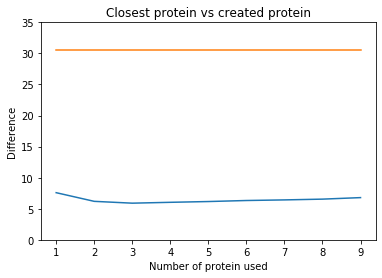

In [86]:
dist_list = []
min_dist = []
np.random.seed(4)
l = np.random.choice(np.array(protein_labels)[1:,1], 100, replace = False)
print(l)
for n in range(1,10):
    dl_ = []
    ml_ = []
    for protein_sel in l:
        distances = get_distance(protein_sel)
        ml_.append(min(distances))
        pred, act = get_similar(protein_sel = protein_sel, num = n)
        dl_.append(np.sum((pred-act)**2, axis = 0))
    dist_list.append(np.mean(dl_))
    min_dist.append(np.mean(ml_))
        
plt.plot(range(1,10), dist_list, range(1,10), min_dist) 
axes = plt.gca()
plt.title("Closest protein vs created protein")
plt.xlabel("Number of protein used")
plt.ylabel("Difference")
axes.set_ylim([0,35])
plt.show()

['CARS' 'RELA' 'DDR2' 'NNT' 'CA1' 'AKT2' 'HTR3A' 'SLC5A1' 'STK39' 'IMPDH2'
 'NDUFS7' 'PPP2CA' 'RETSAT' 'NAGK' 'NARS2' 'SDS' 'EARS2' 'AZGP1' 'CTSL1'
 'MDH2' 'FUCA1' 'SHH' 'MAP3K2' 'PIM3' 'GSTM3' 'PSAT1' 'PPIG' 'CHRFAM7A'
 'CALR' 'CYP2J2' 'PLK1' 'CYP2C8' 'RPL23' 'RORC' 'SPTLC1' 'CAMK2G' 'TH'
 'TLR8' 'NDUFB1' 'TNNI3K' 'DCK' 'COPG1' 'MAPK6' 'RYR1' 'ARPC4' 'RSL24D1'
 'NAE1' 'IGFBP3' 'CHRNA3' 'ADAM17' 'MAPKAPK5' 'CYSLTR1' 'TARS' 'PLA2G4A'
 'FCGR1A' 'TARS2' 'S100A4' 'SPTLC2' 'SLC6A4' 'IVD' 'GUSB' 'NR0B2' 'CXCL1'
 'C1R' 'FRK' 'ALDOA' 'DDAH2' 'CATSPER4' 'GABRA3' 'CD3D' 'ACVRL1' 'HDAC11'
 'GRK1' 'CHRNA2' 'NUAK1' 'PDHA1' 'HSD17B1' 'RBM14' 'AGXT2' 'PRDX2' 'LCT'
 'UGDH' 'BLM' 'ALPP' 'CKB' 'HIPK2' 'GRIK4' 'GNRHR' 'CLK2' 'PLEKHA4' 'GLI1'
 'IMMT' 'RRM2B' 'SOD1' 'CDK6' 'TLR9' 'KCNMB4' 'CATSPER2' 'MMP16' 'ACSS2']


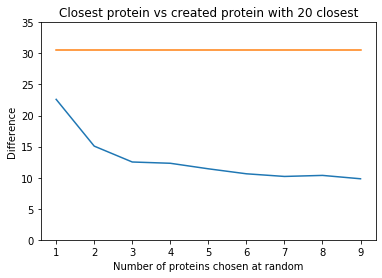

In [88]:
### picking out of 20 closest ###
dist_list = []
min_dist = []
np.random.seed(4)
l = np.random.choice(np.array(protein_labels)[1:,1], 100, replace = False)
print(l)
for n in range(1,10):
    d_ = []
    m_ = []
    for protein_sel in l:
        distances = get_distance(protein_sel)
        m_.append(min(distances))
        pred, act = get_similar(protein_sel = protein_sel, num = n)
        d_.append(np.sum((pred-act)**2, axis = 0))
    dist_list.append(np.mean(d_))
    min_dist.append(np.mean(m_))
        
plt.plot(range(1,10), dist_list, range(1,10), min_dist)  
plt.title("Closest protein vs created protein with 20 closest")
plt.xlabel("Number of proteins chosen at random")
plt.ylabel("Difference")
axes = plt.gca()
axes.set_ylim([0,35])
plt.show()

['CARS' 'RELA' 'DDR2' 'NNT' 'CA1' 'AKT2' 'HTR3A' 'SLC5A1' 'STK39' 'IMPDH2'
 'NDUFS7' 'PPP2CA' 'RETSAT' 'NAGK' 'NARS2' 'SDS' 'EARS2' 'AZGP1' 'CTSL1'
 'MDH2' 'FUCA1' 'SHH' 'MAP3K2' 'PIM3' 'GSTM3' 'PSAT1' 'PPIG' 'CHRFAM7A'
 'CALR' 'CYP2J2' 'PLK1' 'CYP2C8' 'RPL23' 'RORC' 'SPTLC1' 'CAMK2G' 'TH'
 'TLR8' 'NDUFB1' 'TNNI3K' 'DCK' 'COPG1' 'MAPK6' 'RYR1' 'ARPC4' 'RSL24D1'
 'NAE1' 'IGFBP3' 'CHRNA3' 'ADAM17' 'MAPKAPK5' 'CYSLTR1' 'TARS' 'PLA2G4A'
 'FCGR1A' 'TARS2' 'S100A4' 'SPTLC2' 'SLC6A4' 'IVD' 'GUSB' 'NR0B2' 'CXCL1'
 'C1R' 'FRK' 'ALDOA' 'DDAH2' 'CATSPER4' 'GABRA3' 'CD3D' 'ACVRL1' 'HDAC11'
 'GRK1' 'CHRNA2' 'NUAK1' 'PDHA1' 'HSD17B1' 'RBM14' 'AGXT2' 'PRDX2' 'LCT'
 'UGDH' 'BLM' 'ALPP' 'CKB' 'HIPK2' 'GRIK4' 'GNRHR' 'CLK2' 'PLEKHA4' 'GLI1'
 'IMMT' 'RRM2B' 'SOD1' 'CDK6' 'TLR9' 'KCNMB4' 'CATSPER2' 'MMP16' 'ACSS2']


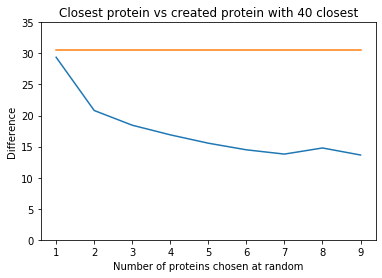

In [91]:
### picking out of 40 closest ###
dist_list = []
min_dist = []
np.random.seed(4)
l = np.random.choice(np.array(protein_labels)[1:,1], 100, replace = False)
print(l)
for n in range(1,10):
    d_ = []
    m_ = []
    for protein_sel in l:
        distances = get_distance(protein_sel)
        m_.append(min(distances))
        pred, act = get_similar(protein_sel = protein_sel, num = n)
        d_.append(np.sum((pred-act)**2, axis = 0))
    dist_list.append(np.mean(d_))
    min_dist.append(np.mean(m_))
        
plt.plot(range(1,10), dist_list, range(1,10), min_dist)  
plt.title("Closest protein vs created protein with 40 closest")
plt.xlabel("Number of proteins chosen at random")
plt.ylabel("Difference")
axes = plt.gca()
axes.set_ylim([0,35])
plt.show()

['CARS' 'RELA' 'DDR2' 'NNT' 'CA1' 'AKT2' 'HTR3A' 'SLC5A1' 'STK39' 'IMPDH2'
 'NDUFS7' 'PPP2CA' 'RETSAT' 'NAGK' 'NARS2' 'SDS' 'EARS2' 'AZGP1' 'CTSL1'
 'MDH2' 'FUCA1' 'SHH' 'MAP3K2' 'PIM3' 'GSTM3' 'PSAT1' 'PPIG' 'CHRFAM7A'
 'CALR' 'CYP2J2' 'PLK1' 'CYP2C8' 'RPL23' 'RORC' 'SPTLC1' 'CAMK2G' 'TH'
 'TLR8' 'NDUFB1' 'TNNI3K' 'DCK' 'COPG1' 'MAPK6' 'RYR1' 'ARPC4' 'RSL24D1'
 'NAE1' 'IGFBP3' 'CHRNA3' 'ADAM17' 'MAPKAPK5' 'CYSLTR1' 'TARS' 'PLA2G4A'
 'FCGR1A' 'TARS2' 'S100A4' 'SPTLC2' 'SLC6A4' 'IVD' 'GUSB' 'NR0B2' 'CXCL1'
 'C1R' 'FRK' 'ALDOA' 'DDAH2' 'CATSPER4' 'GABRA3' 'CD3D' 'ACVRL1' 'HDAC11'
 'GRK1' 'CHRNA2' 'NUAK1' 'PDHA1' 'HSD17B1' 'RBM14' 'AGXT2' 'PRDX2' 'LCT'
 'UGDH' 'BLM' 'ALPP' 'CKB' 'HIPK2' 'GRIK4' 'GNRHR' 'CLK2' 'PLEKHA4' 'GLI1'
 'IMMT' 'RRM2B' 'SOD1' 'CDK6' 'TLR9' 'KCNMB4' 'CATSPER2' 'MMP16' 'ACSS2']


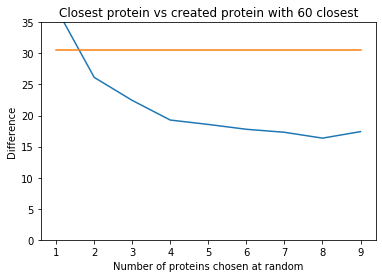

In [93]:
### picking out of 60 closest ###
dist_list = []
min_dist = []
np.random.seed(4)
l = np.random.choice(np.array(protein_labels)[1:,1], 100, replace = False)
print(l)
for n in range(1,10):
    d_ = []
    m_ = []
    for protein_sel in l:
        distances = get_distance(protein_sel)
        m_.append(min(distances))
        pred, act = get_similar(protein_sel = protein_sel, num = n)
        d_.append(np.sum((pred-act)**2, axis = 0))
    dist_list.append(np.mean(d_))
    min_dist.append(np.mean(m_))
        
plt.plot(range(1,10), dist_list, range(1,10), min_dist)  
plt.title("Closest protein vs created protein with 60 closest")
plt.xlabel("Number of proteins chosen at random")
plt.ylabel("Difference")
axes = plt.gca()
axes.set_ylim([0,35])
plt.show()

## Plan: 

Linear Graph Autoencoder

In [45]:
D = np.identity(1915) * math.sqrt(1/1915)
D

array([[0.02285155, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02285155, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02285155, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02285155, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02285155,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02285155]])

In [46]:
A_sym = np.dot(np.dot(D,protein_molecular_sim + np.identity(1915)),D)
A_sym

array([[1.04438642e-03, 2.27676240e-04, 3.25326371e-04, ...,
        1.31070496e-04, 1.13315927e-04, 1.70757180e-04],
       [2.27676240e-04, 1.04438642e-03, 2.38120104e-04, ...,
        1.86945170e-04, 1.10704961e-04, 1.66057441e-04],
       [3.25326371e-04, 2.38120104e-04, 1.04438642e-03, ...,
        1.31070496e-04, 1.14882507e-04, 1.70757180e-04],
       ...,
       [1.31070496e-04, 1.86945170e-04, 1.31070496e-04, ...,
        1.04438642e-03, 9.45169713e-05, 9.45169713e-05],
       [1.13315927e-04, 1.10704961e-04, 1.14882507e-04, ...,
        9.45169713e-05, 1.04438642e-03, 3.73368146e-04],
       [1.70757180e-04, 1.66057441e-04, 1.70757180e-04, ...,
        9.45169713e-05, 3.73368146e-04, 1.04438642e-03]])

In [47]:
W = np.random.normal(size = (1915,5))
Z = np.dot(A_sym,W)
Z

array([[-2.66170974e-03,  3.96955800e-03, -8.55995199e-03,
         1.75971401e-02, -2.06787390e-03],
       [-7.99337678e-03,  2.60247089e-03, -2.14925487e-03,
         9.39781795e-03, -2.59610204e-04],
       [-2.00304966e-03,  1.60281721e-03, -9.62491863e-03,
         1.86480301e-02,  9.66637459e-04],
       ...,
       [-1.03779333e-04,  5.51710648e-05, -8.25019075e-03,
         5.11920648e-03, -4.72969039e-03],
       [ 2.72582890e-03,  4.30239080e-03, -5.65073260e-03,
         6.84426188e-03, -1.91093781e-03],
       [-1.38475620e-03,  1.70835889e-03, -6.21001361e-03,
         1.41374655e-02,  2.32054606e-03]])

In [48]:
A_hat = np.dot(Z,Z.T)
A_hat.shape

(1915, 1915)

In [49]:
sig = 1/(1 + np.exp(-A_hat))
sig

array([[0.50010251, 0.50005398, 0.50010506, ..., 0.50004275, 0.50004565,
        0.5000769 ],
       [0.50005398, 0.50004092, 0.50005397, ..., 0.50001701, 0.50001659,
        0.50004028],
       [0.50010506, 0.50005397, 0.50011198, ..., 0.50004265, 0.5000454 ,
        0.50008279],
       ...,
       [0.50004275, 0.50001701, 0.50004265, ..., 0.50002916, 0.50002266,
        0.50002822],
       [0.50004565, 0.50001659, 0.5000454 , ..., 0.50002266, 0.50002709,
        0.50003275],
       [0.5000769 , 0.50004028, 0.50008279, ..., 0.50002822, 0.50003275,
        0.50006216]])

In [50]:
(sig - protein_molecular_sim)**2

,ADA,AKT3,GNPDA1,HDAC6,HDAC5,CDH5,PARP2,PARP3,ABCC9,NR1H3,...,LCMT2,CDK11B,TLK1,NUAK1,CDC25B,XYLB,OXSR1,HS3ST3A1,NR1I3,NR1H4
ADA,0.249897,0.004103,0.015103,0.015847,5.911486e-03,0.041164,0.002590,0.030650,0.010623,0.010220,...,0.000066,0.006093,0.000787,0.006878,0.005914,0.097334,1.595334e-03,0.062022,0.080115,0.029956
AKT3,0.004103,0.249959,0.001941,0.002595,4.983173e-05,0.011437,0.000024,0.033135,0.022510,0.017968,...,0.000844,0.180593,0.234213,0.112868,0.002406,0.043683,1.648014e-01,0.020169,0.082954,0.033139
GNPDA1,0.015103,0.001941,0.249888,0.010791,2.796356e-03,0.071225,0.012074,0.019620,0.006252,0.008483,...,0.000723,0.003976,0.000009,0.018477,0.008445,0.097329,4.866271e-04,0.062022,0.078425,0.029958
HDAC6,0.015847,0.002595,0.010791,0.249871,9.112638e-02,0.029540,0.009975,0.061543,0.001094,0.013898,...,0.005608,0.002802,0.005032,0.011433,0.013430,0.126719,3.592323e-03,0.093053,0.047546,0.000364
HDAC5,0.005911,0.000050,0.002796,0.091126,2.498711e-01,0.014853,0.002389,0.044553,0.006096,0.019569,...,0.000524,0.000254,0.000142,0.003591,0.013199,0.093010,4.206470e-09,0.051096,0.027906,0.002818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLB,0.097334,0.043683,0.097329,0.126719,9.300978e-02,0.138362,0.047077,0.017956,0.113559,0.138363,...,0.047078,0.043685,0.016902,0.016904,0.136884,0.249979,1.690180e-02,0.028561,0.138378,0.138369
OXSR1,0.001595,0.164801,0.000487,0.003592,4.206470e-09,0.017940,0.000063,0.051091,0.018780,0.013008,...,0.000964,0.116254,0.166426,0.067577,0.000402,0.016902,2.499552e-01,0.031691,0.078971,0.028915
HS3ST3A1,0.062022,0.020169,0.062022,0.093053,5.109611e-02,0.101789,0.010210,0.000726,0.070770,0.101784,...,0.010209,0.020169,0.031691,0.031692,0.099250,0.028561,3.169053e-02,0.249971,0.101775,0.101779
NR1I3,0.080115,0.082954,0.078425,0.047546,2.790582e-02,0.064035,0.078428,0.079544,0.044956,0.069146,...,0.082970,0.045804,0.078972,0.075640,0.080113,0.138378,7.897131e-02,0.101775,0.249973,0.046211


## This could totally be wrong...

$$ \tilde{A} = D^{-1/2} (A + In) D^{-1/2} $$

$$ Z = \tilde{A} W$$ 

$$ \hat{A} = \sigma({ZZ^{T}})$$



In [94]:
class graph_autoencoder(torch.nn.Module):
    
    def __init__(self, encoded_dim,length,graph):
        super().__init__()
        #fully connected graph
        self.D = torch.from_numpy(np.identity(length) * math.sqrt(1/length)).float()
        self.A_sym = np.dot(np.dot(self.D,graph + np.identity(length)),self.D)
        self.A_sym = torch.from_numpy(self.A_sym).float()
        np.random.seed(4)
        self.W = nn.Parameter(torch.from_numpy(np.random.normal(size = (length,encoded_dim))).float())
        self.sig = nn.Sigmoid()
    def forward(self):
        Z = torch.mm(self.A_sym,self.W)
        A_hat = torch.mm(Z,Z.T)
        sig = self.sig(A_hat)
        return A_hat
    def encode(self):
        with torch.no_grad():
            Z = torch.mm(self.A_sym,self.W)
        return Z

In [95]:
def run_model(l_r, epochs, gamma, milestones, encoded_dim, length, graph):
    l_r = l_r
    model = graph_autoencoder(encoded_dim, length, graph)
    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=l_r)
    epochs = epochs
    x_milestones = milestones
    x_gamma = gamma
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=x_milestones, gamma=x_gamma)
    
    torch.manual_seed(4)
    l = []
    
    for epoch in range(epochs):
       
        output = model()
        loss = criterion(output, torch.from_numpy(graph.values).float())
        l.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    plt.plot(range(epochs),l)
    return l, model

### Since we don't know if its working test with small graph

(only works with fully connected graphs)

In [96]:
test_graph = np.array(np.ones((5,5)))

In [97]:
test_graph[0] = np.array([1,.1,.1,.9,.5])
test_graph[1] = np.array([.1,1,.9,.1,.5])
test_graph[2] = np.array([.1,.9,1,.1,.5])
test_graph[3] = np.array([.9,.1,.1,1,.5])
test_graph[4] = np.array([.5,.5,.5,.5,1])

In [98]:
test_graph = pd.DataFrame(test_graph)
test_graph

,0,1,2,3,4
0,1.0,0.1,0.1,0.9,0.5
1,0.1,1.0,0.9,0.1,0.5
2,0.1,0.9,1.0,0.1,0.5
3,0.9,0.1,0.1,1.0,0.5
4,0.5,0.5,0.5,0.5,1.0


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


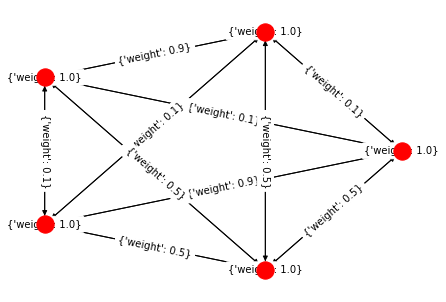

In [99]:
G = nx.from_numpy_matrix(np.matrix(test_graph.values), create_using=nx.DiGraph)
layout = nx.circular_layout(G)
nx.draw(G, layout)
nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()

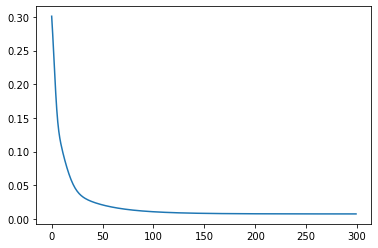

In [100]:
l, model = run_model(1, 300, .5, [], 2, 5, test_graph)

In [101]:
with torch.no_grad():
    Z = torch.mm(model.A_sym,model.W)
Z = model.encode()

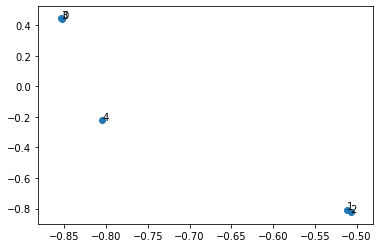

In [102]:
fig, ax = plt.subplots()
ax.scatter(Z.T[0], Z.T[1])
n = [0,1,2,3,4]
for i, txt in enumerate(n):
    ax.annotate(txt, (Z.T[0][i], Z.T[1][i]))

In [103]:
model()

tensor([[0.9231, 0.0791, 0.0692, 0.9247, 0.5874],
        [0.0791, 0.9126, 0.9223, 0.0780, 0.5915],
        [0.0692, 0.9223, 0.9322, 0.0681, 0.5915],
        [0.9247, 0.0780, 0.0681, 0.9263, 0.5877],
        [0.5874, 0.5915, 0.5915, 0.5877, 0.6971]], grad_fn=<MmBackward>)

tensor(0.0113, grad_fn=<MseLossBackward>)


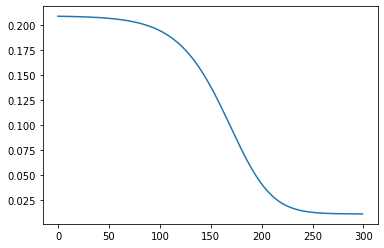

In [104]:
l, model_molecular = run_model(100, 300, .5, [], 3, 1915, protein_molecular_sim)
print(l[-1])

tensor(0.0258, grad_fn=<MseLossBackward>)


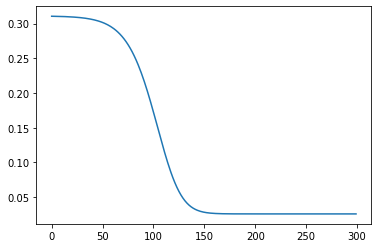

In [105]:
l, model_cellular = run_model(100, 300, .5, [], 3, 1915, protein_cellular_sim)
print(l[-1])

tensor(0.0010, grad_fn=<MseLossBackward>)


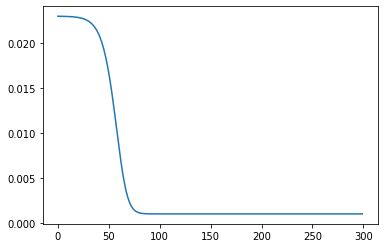

In [106]:
l, model_seq = run_model(10000, 300, .5, [], 3, 1915, protein_sequence_sim)
print(l[-1])

tensor(0.0132, grad_fn=<MseLossBackward>)


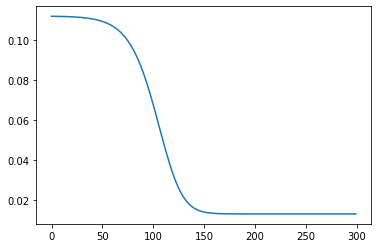

In [107]:
l, model_bio = run_model(500, 300, .5, [], 3, 1915, protein_biological_sim)
print(l[-1])

### Prediction labels

Get labels of form: 

(Protein, Drug, 0) --> if unknown Interacting Pair

(Protein, Drug, 1) --> if Interacting Pair

Model(Protein, Drug) = +1/0

Train/Validations split for training. Held out test on 10 randomly selected samples. 

For the held out test, data for those protein are not trained on. Instead after training, it will be evaluated on the "guessed protein". 

#### Experiments: 
1. MLP with concatenated Protein and Drug information
2. Encoding dimension vs accuracy 
3. Try predicting close drugs using some sort of multi-label or regression?



Total number of possible interactions: 1915 x 732 = 1401780

Total number of positive interactions: 134573

Randomly sample equal number of unknown-interacting pairs, and pray model learns some useful features. 



https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-019-0691-1

In [108]:
protein_to_disease.shape

(1915, 440)

In [109]:
drug_to_disease.shape

(732, 440)

In [110]:
dis_to_drug_map = {}
## loop over all diseases add to map from disease to drugs
for idx,dis in enumerate(drug_to_disease.T):
    drugs = []
    for i in np.nonzero(dis)[0]:
        drugs.append((drug_labels[1:][i],i))
    dis_to_drug_map[idx] = drugs


In [111]:
p_to_drug_map = {}
c = 0
for idx,dis in enumerate(protein_to_disease):
    drugs = []
    for i in np.nonzero(dis)[0]:
        for item in dis_to_drug_map[i]:
            drugs.append(item)
            c = c + 1
    p_to_drug_map[idx] = drugs

In [112]:
protein_to_disease.shape

(1915, 440)

In [113]:
c

134573

In [114]:
def pos_and_neg_ex(pos,seed):
    pos_ex = []
    neg_ex = []
    for protein in pos:
        possib = list(range(732))
        for drug in pos[protein]:
            pos_ex.append([protein,drug[1]])
            if drug[1] in possib:
                possib.remove(drug[1])
        np.random.seed(seed)
        for chosen in np.random.choice(possib, 70, replace = False):
            neg_ex.append([protein, chosen])
    return pos_ex, neg_ex

In [115]:
p,n = pos_and_neg_ex(p_to_drug_map,4)

In [119]:
len(p)

134573

In [120]:
len(n)

134050

In [121]:
np.array(drug_labels)[1:,1].shape

(732,)

In [122]:
drug_chem_sim = pd.DataFrame(d_chem, index = np.array(drug_labels)[1:,1], columns = np.array(drug_labels)[1:,1])
drug_ther_sim = pd.DataFrame(d_ther, index = np.array(drug_labels)[1:,1], columns = np.array(drug_labels)[1:,1])
drug_seq_sim = pd.DataFrame(d_seq, index = np.array(drug_labels)[1:,1], columns = np.array(drug_labels)[1:,1])
drug_bio_sim = pd.DataFrame(d_bio, index = np.array(drug_labels)[1:,1], columns = np.array(drug_labels)[1:,1])
drug_cellular_sim = pd.DataFrame(d_cellular, index = np.array(drug_labels)[1:,1], columns = np.array(drug_labels)[1:,1])
drug_molecular_sim = pd.DataFrame(d_molecular, index = np.array(drug_labels)[1:,1], columns = np.array(drug_labels)[1:,1])


tensor(0.0087, grad_fn=<MseLossBackward>)


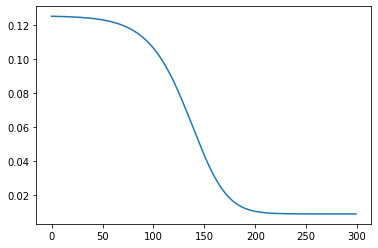

In [123]:
l, drug_chem_encoded = run_model(100, 300, .5, [], 3, 732, drug_chem_sim)
print(l[-1])

tensor(0.0354, grad_fn=<MseLossBackward>)


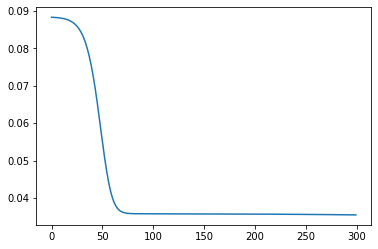

In [124]:
l, drug_ther_encoded = run_model(1000, 300, .5, [], 3, 732, drug_ther_sim)
print(l[-1])

tensor(0.0025, grad_fn=<MseLossBackward>)


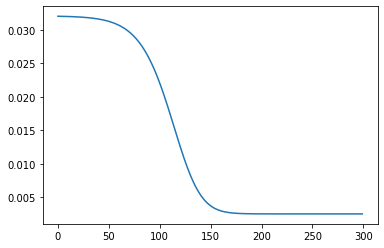

In [125]:
l, drug_seq_encoded = run_model(1000, 300, .5, [], 3, 732, drug_seq_sim)
print(l[-1])

tensor(0.0057, grad_fn=<MseLossBackward>)


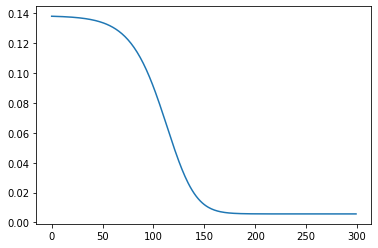

In [126]:
l, drug_bio_encoded = run_model(100, 300, .5, [], 3, 732, drug_bio_sim)
print(l[-1])

tensor(0.0104, grad_fn=<MseLossBackward>)


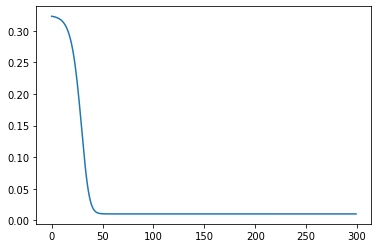

In [127]:
l, drug_cellular_encoded = run_model(100, 300, .5, [], 3, 732, drug_cellular_sim)
print(l[-1])

tensor(0.0072, grad_fn=<MseLossBackward>)


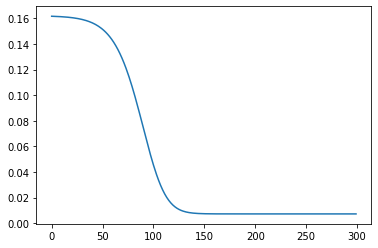

In [128]:
l, drug_moleclar_encoded = run_model(100, 300, .5, [], 3, 732, drug_molecular_sim)
print(l[-1])

In [129]:
def dim_vs_accuracy(protein_dim, drug_dim):
    # Calculate drug lower dimentional data
    l, drug_chem_encoded = run_model(100, 300, .5, [], drug_dim, 732, drug_chem_sim)
    l, drug_ther_encoded = run_model(1000, 300, .5, [], drug_dim, 732, drug_ther_sim)
    l, drug_seq_encoded = run_model(1000, 300, .5, [], drug_dim, 732, drug_seq_sim)
    l, drug_bio_encoded = run_model(100, 300, .5, [], drug_dim, 732, drug_bio_sim)
    l, drug_cellular_encoded = run_model(100, 300, .5, [], drug_dim, 732, drug_cellular_sim)
    l, drug_moleclar_encoded = run_model(100, 300, .5, [], drug_dim, 732, drug_molecular_sim)

    with torch.no_grad():
        drug_low_dim = np.concatenate((drug_chem_encoded.encode(),drug_ther_encoded.encode(), drug_seq_encoded.encode(), drug_bio_encoded.encode(), drug_cellular_encoded.encode(), drug_moleclar_encoded.encode()), axis = 1)
    plt.show()
    
    
    #calculate protein lower dimentional data
    l, model_molecular = run_model(100, 300, .5, [], protein_dim, 1915, protein_molecular_sim)
    l, model_cellular = run_model(100, 300, .5, [], protein_dim, 1915, protein_cellular_sim)
    l, model_seq = run_model(10000, 300, .5, [], protein_dim, 1915, protein_sequence_sim)
    l, model_bio = run_model(500, 300, .5, [], protein_dim, 1915, protein_biological_sim)
    
    with torch.no_grad():
        protein_low_dim = np.concatenate(( model_molecular.encode(), model_cellular.encode(), model_seq.encode(), model_bio.encode()), axis = 1)
    plt.show()
    print("Done Encoding")
    print("Protein dim reduced to = " + str(protein_low_dim.shape))
    print("Drug dim reduced to = " + str(drug_low_dim.shape))
    
    seed = 4
    pos, neg = pos_and_neg_ex(p_to_drug_map,seed)
    p_data = np.concatenate((protein_low_dim[np.array(pos)[:,0]], protein_low_dim[np.array(neg)[:,0]]), axis = 0)
    d_data = np.concatenate((drug_low_dim[np.array(pos)[:,1]], drug_low_dim[np.array(neg)[:,1]]))
    labels = np.concatenate((np.tile([1],len(pos)), np.tile([0],len(neg))))
    print(p_data.shape)
    print(d_data.shape)
    print(labels.shape)
    return p_data, d_data, labels

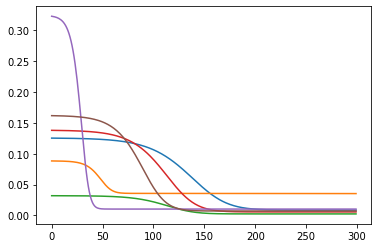

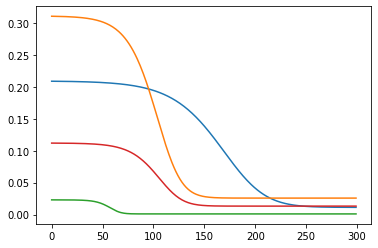

Done Encoding
Protein dim reduced to = (1915, 12)
Drug dim reduced to = (732, 18)
(268623, 12)
(268623, 18)
(268623,)


In [130]:
p,d,l = dim_vs_accuracy(protein_dim = 3, drug_dim = 3)

In [131]:
class network(nn.Module): 
    def __init__(self,shape):
        super(network, self).__init__() 
        self.fc1 = nn.Linear(shape[0],shape[1])
        self.fc2 = nn.Linear(shape[1],shape[2])
        self.fc3 = nn.Linear(shape[2],shape[3])
        self.fc4 = nn.Linear(shape[3],shape[4])
        self.dropout = nn.Dropout(p=.1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [139]:
def run_mlp(x_milestones, x_gamma, data, labels, x_learning_rate, x_momentum, x_batch_size, x_epochs, hidden):
    torch.manual_seed(4)
    batch_size = x_batch_size
    learning_rate = x_learning_rate
    epochs = x_epochs
    model = network([data.shape[1],hidden, hidden, hidden, 1]) 
    optim = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = x_momentum)
    loss_function = nn.BCEWithLogitsLoss(reduction='mean')
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=x_milestones, gamma=x_gamma)

    
    all_training_loss = []
    all_val_loss = []
    
    training_data, val_data, training_labels, val_labels = train_test_split(data, labels, test_size=0.15, random_state=4)
    training_data = torch.from_numpy(training_data).float()
    val_data = torch.from_numpy(val_data).float()
    training_labels = torch.from_numpy(training_labels).float()
    val_labels = torch.from_numpy(val_labels).float()
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        for idx in range(0, training_data.shape[0], batch_size):
            batch_data = training_data[idx : idx+batch_size]
            batch_labels = training_labels[idx:idx+batch_size]
            model_output = model(batch_data)
            model_output = model_output.reshape((-1))
            loss = loss_function(model_output, batch_labels)
            train_loss.append(loss.item())
            optim.zero_grad()
            loss.backward()
            optim.step()
    
    
        #Validation phase
        model.eval()
        val_loss = []
    
        for idx in range(0, val_data.shape[0], batch_size):
            with torch.no_grad():   
                batch_data = val_data[idx : idx+batch_size] 
                batch_labels = val_labels[idx:idx+batch_size]
                model_output = model(batch_data)
                model_output = model_output.reshape((-1))
                loss = loss_function(model_output, batch_labels)
                val_loss.append(loss.item())
        #print("Epoch : {}, Train loss: {} , Val loss: {}".format(epoch, np.mean(train_loss), np.mean(val_loss)))
        all_training_loss.append(np.mean(train_loss))
        all_val_loss.append(np.mean(val_loss))
        
        scheduler.step()
    
    
    model.eval()
    with torch.no_grad(): 
        model_output_train = model(training_data)
        model_output_val = model(val_data)
        
    sigmoid = nn.Sigmoid()
    model_output_train = np.array(sigmoid(model_output_train))
    np.putmask(model_output_train, model_output_train >= .5, 1)
    np.putmask(model_output_train, model_output_train < .5, 0)
    print("Train Accuracy = " + str(accuracy_score(training_labels, model_output_train)*100))

    model_output_val = np.array(sigmoid(model_output_val))
    np.putmask(model_output_val, model_output_val >= .5, 1)
    np.putmask(model_output_val, model_output_val < .5, 0)
    print("Validation Accuracy = " + str(accuracy_score(val_labels, model_output_val)*100))
    
    return all_training_loss, all_val_loss, model

In [140]:
data = np.concatenate((p,d), axis = 1)
print(data.shape)
print(l.shape)

(268623, 30)
(268623,)


In [141]:
x_learning_rate = .2
x_momentum = 0.2
x_batch_size = 64
x_epochs = 250
x_milestones = [130]
x_gamma = .5
tl,vl,m = run_mlp(x_milestones, x_gamma, data, l, x_learning_rate, x_momentum, x_batch_size, x_epochs, hidden = 128)

Train Accuracy = 83.78392582632955
Validation Accuracy = 83.52111976969276


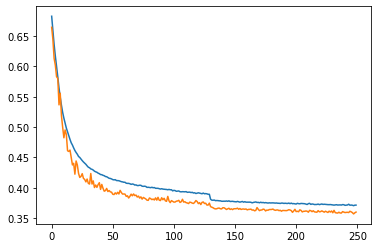

In [142]:
plt.plot(range(0,x_epochs), tl, vl)

#### Pick a protein --> guess it --> make graph encoder with protein removed --> train on protein removed --> test